# What are most of the neurons "talking about"?

# Section 1. Load everything again. 

In [ ]:
import os
import numpy as np
from scipy import io
from scipy import stats
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# rerun all the prep and processing from mesoscope1.ipynb
mname, datexp, blk = 'TX39', '2019_05_31', '1' 
root      = '/home/neuraldata/data/meso'
mov    = np.load(os.path.join(root, 'mov.npy')) 
iframe    = np.load(os.path.join(root, 'iframe.npy')) 
ops = np.load(os.path.join(root, 'suite2p', 'combined', 'ops.npy'), allow_pickle=True).item()
spks = np.load(os.path.join(root, 'suite2p', 'combined', 'spks.npy'))
stat = np.load(os.path.join(root, 'suite2p', 'combined', 'stat.npy'), allow_pickle=True)
ypos = [stat[k]['med'][0] for k in range(len(stat))]
xpos = [stat[k]['med'][1] for k in range(len(stat))]
ypos, xpos = np.array(ypos), np.array(xpos)
ypos, xpos = ypos/.5, xpos/.75 
dt = 1 # time offset 
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
mov = mov[:, :, ivalid]
S = spks[:, iframe+dt]
S = stats.zscore(S, axis=1) # z-score the neural activity before doing anything
print('total neurons %d'%len(stat))
print('recorded from an area of %2.2f um by %2.2f um'%(np.ptp(ypos), np.ptp(xpos)))

total neurons 18795
recorded from an area of 1606.00 um by 2342.00 um


# Section 2. Run PCA

In [56]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components = 100) # PCA is a class. Here we define the model.
pca_model.fit(S) # here we fit the model
# most models in sklearn work this way (linear regression, LASSO, ICA, tSNE)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

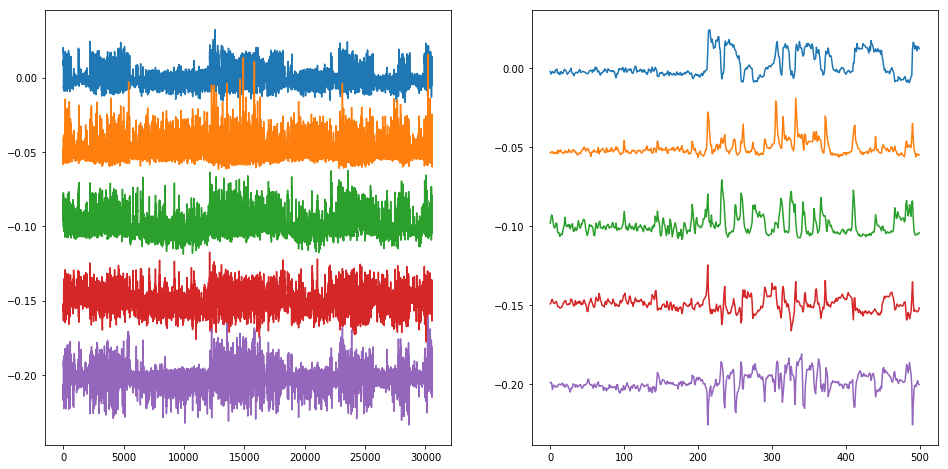

In [44]:
# plot some components
X = pca_model.components_

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
for j in range(5):
    plt.plot(X[j] - j * .05)
plt.subplot(1,2,2)
for j in range(5):
    plt.plot(X[j, 2000:2500] - j * .05)
plt.show()

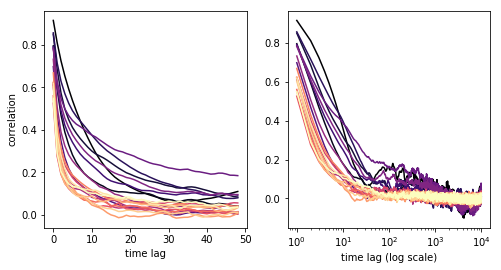

In [60]:
# compute the autocorrelogram of these components 
from numpy.fft import fft, ifft

num_PC = 20

# this function uses the Fourier trick
def autocorr(X, axis=-1):    
    fX = fft(X, axis=axis)
    acc = np.real(ifft(fX * np.conj(fX), axis=axis))
    return acc

X   = pca_model.components_
acc = autocorr(X)

# sample some colors from the magma colormap
colormap = plt.cm.magma
colors   = [colormap(i) for i in np.linspace(0, 1,num_PC)]

# bright colors are later components
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for j in range(num_PC):
    plt.plot(acc[j, 1:50].T, c = colors[j])
plt.ylabel('correlation')
plt.xlabel('time lag')

plt.subplot(1,2,2)
for j in range(num_PC):
    plt.semilogx(np.arange(1,10000), acc[j, 1:10000], c = colors[j])
plt.xlabel('time lag (log scale)')
plt.show()

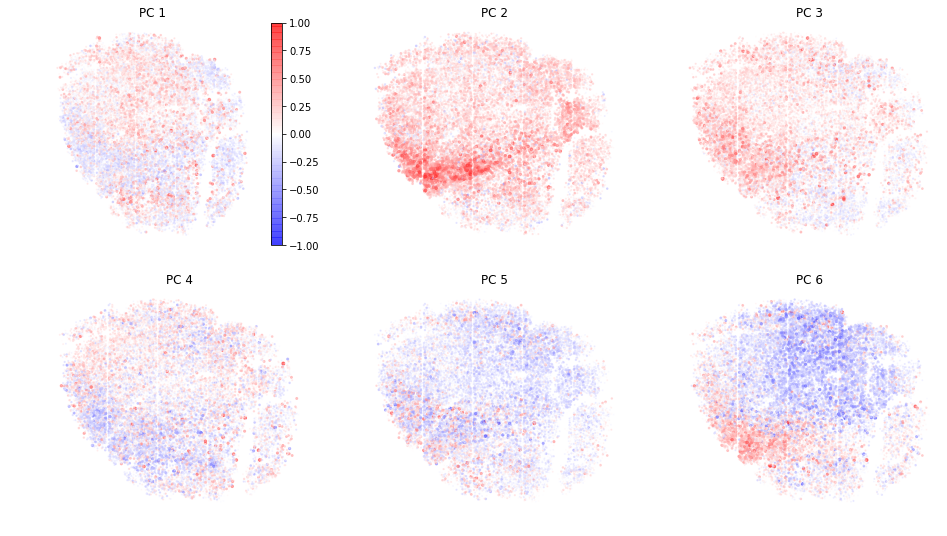

In [64]:
# color cells according to their PC coefficients
plt.figure(figsize=(16,9))
for j in range(6):
    pc0 = S @ pca_model.components_[j]
    pc0 = pc0/np.max(np.abs(pc0)) # normalize components
    lam = np.abs(pc0)    
    plt.subplot(2,3,1+j)
    plt.scatter(xpos, -ypos, s= 10 * lam, c = pc0, cmap='bwr', alpha = .5, vmin=-1, vmax=1)    
    if j==0:
        plt.colorbar()
    plt.title('PC %d'%(1+j))
    plt.axis('off')

In [8]:
from scipy.stats import zscore
Sp = model.components_
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape

NN, NT = S.shape 

X = np.reshape(mov - 0.5, [-1, NT]) # reshape to Npixels by Ntimepoints
X = stats.zscore(np.abs(X), axis=1)/NT**.5  # z-score each pixel separately

npix = X.shape[0]
ncomps = Sp.shape[0]

B0 = X @ Sp.T # get the receptive fields for each neuron
B0 = np.reshape(B0, (ly, lx, ncomps))

if datexp is '2019_06_04' or datexp is '2019_06_06': # on these dates, the screens were flipped! 
    B0 = np.reshape(B0, [mov.shape[0], 2, int(mov.shape[1]/2), ncomps])
    B0 = np.flip(B0, axis=1)
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], ncomps])
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little


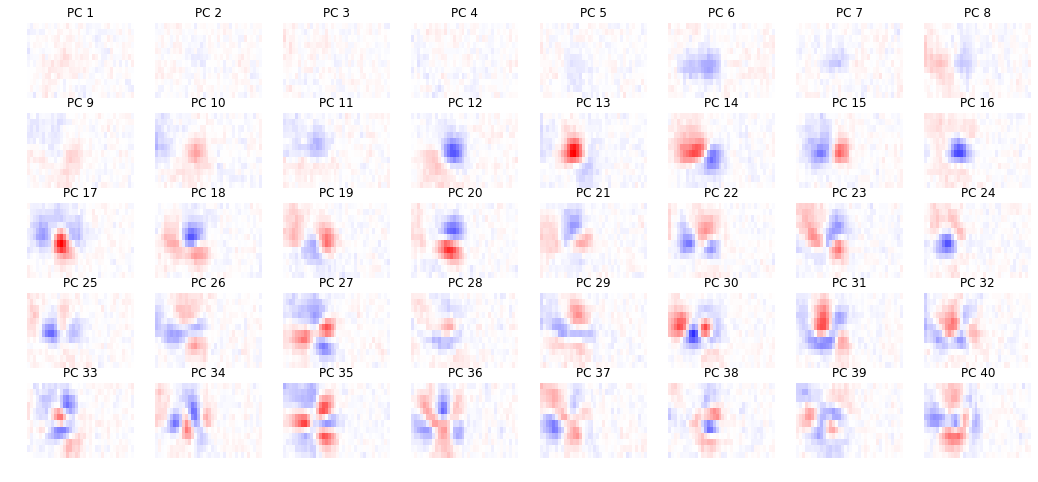

In [9]:
plt.figure(figsize=(18, 8))
rfmax = np.max(B0)
for j in range(40):
    plt.subplot(5,8,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    plt.title('PC %d'%(1+j))
    plt.axis('off')
    
plt.show()    

## Two new mysteries: 
1) why do the biggest components have no receptive fields  
2) why are the receptive fields so distributed

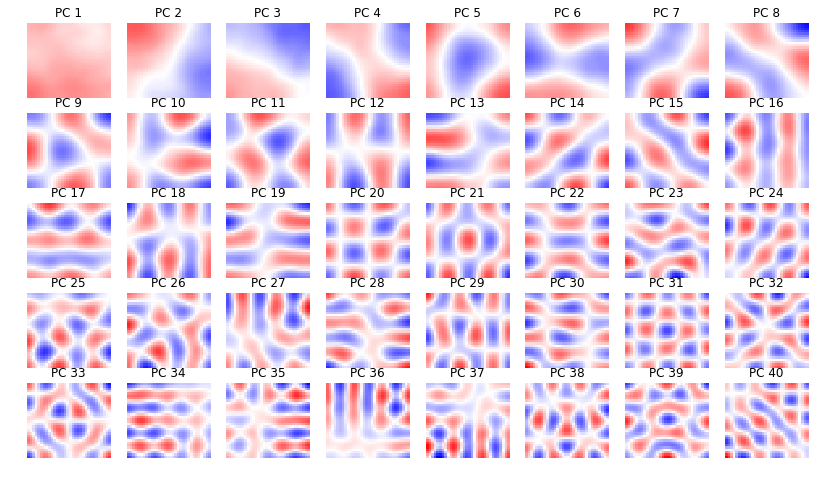

In [10]:
# solve the second mystery: PCA of translation-invariant data always looks like that
# make some random noise and smooth it
nPC = 50

Xn = np.random.randn(10000, 32,32)
Xn = gaussian_filter(Xn, [0, 2, 2])
Xn = np.reshape(Xn, (10000, -1))
model = PCA(n_components= nPC).fit(Xn)

bPC = np.reshape(model.components_.T, (32,32, nPC))
plt.figure(figsize=(14, 8))
rfmax = np.max(bPC)
for j in range(40):
    plt.subplot(5,8,j+1)
    rf = bPC[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    plt.title('PC %d'%(1+j))    
    plt.axis('off')
plt.show()    

# compare with DCT https://en.wikipedia.org/wiki/Discrete_cosine_transform
del Xn    

# Section 3. Run Rastermap 

Rastermap re-arranges neurons in the raster plot based on similarity of activity

In [13]:
from rastermap import Rastermap
model = Rastermap(n_components=1, n_X=100).fit(S) 

nmin 200
0.7239077091217041
9.610335111618042
9.99429178237915
10.045403718948364
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.46s     0        0.0266      2
0.71s    10        0.1054      4
0.94s    20        0.1382      8
1.19s    30        0.1781      18
1.43s    40        0.2085      28
1.67s    50        0.2294      38
1.92s    60        0.2459      48
2.16s    70        0.2590      58
2.40s    80        0.2695      68
2.66s    90        0.2798      78
2.95s    100        0.2895      88
3.20s    110        0.2991      98
3.44s    120        0.2999      98
3.68s   final      0.3000
3.69s upsampled    0.3000


### Sort and smooth neurons along the one-dimensional embedding

In [24]:
from scipy.ndimage import gaussian_filter1d

# this function performs a running average filter over the first dimension of X
def running_average(X, nbin = 50):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y

isort = np.argsort(model.embedding[:,0])
Sfilt = running_average(S[isort, :], 50)
Sfilt = stats.zscore(Sfilt, axis=1)

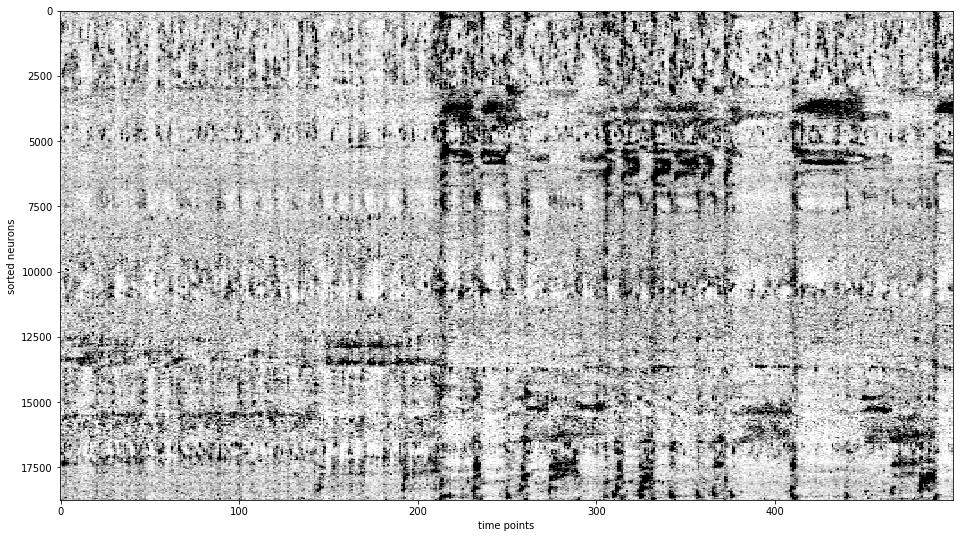

In [77]:
time_range = np.arange(2000,2500)
#time_range = np.arange(12000,12500)

plt.figure(figsize=(16,9))
plt.imshow(-Sfilt[:, time_range], vmin = -2, vmax=1, aspect='auto', cmap='gray')
plt.xlabel('time points')
plt.ylabel('sorted neurons')
plt.show()

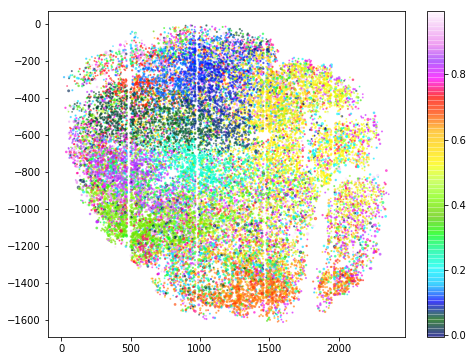

In [22]:
# HERE PLOT cells according to their rastermap embedding
lam = model.lam
plt.figure(figsize=(8,6))
plt.scatter(xpos, -ypos, s = 10 * lam/np.max(lam), c = model.embedding[:,0], cmap='gist_ncar', alpha = .5)
plt.colorbar()

## Do the Rastermap components have receptive fields?

In [54]:
Sp = Sfilt[50::100, :] # take every 100th row in the smoothed raster matrix
ly, lx, nstim = mov.shape

NN, NT = S.shape 

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = stats.zscore(np.abs(X-0.5), axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = .01
ncomps = Sp.shape[0]
B0 = X @ Sp.T # get the receptive fields for each neuron
B0 = np.reshape(B0, [mov.shape[0], mov.shape[1], ncomps])

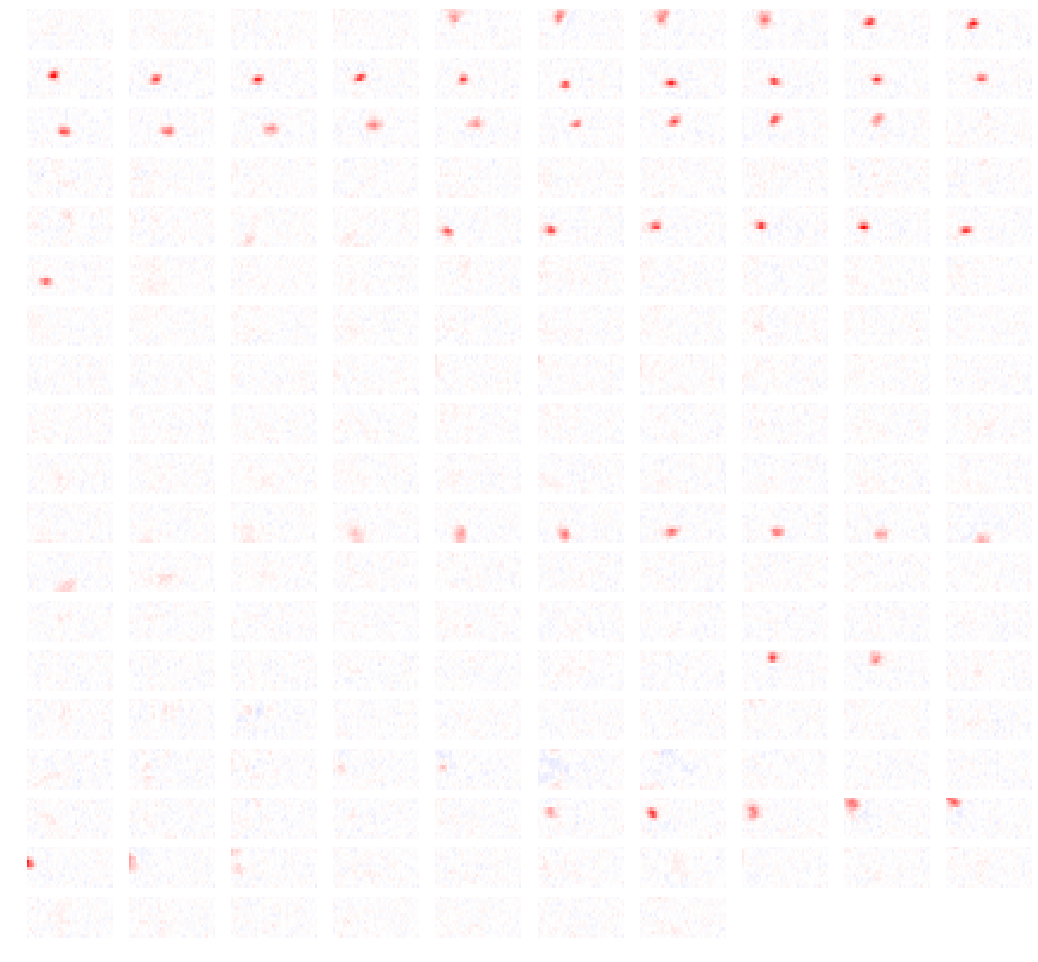

In [55]:
plt.figure(figsize=(18, 18))
rfmax = np.max(B0)
for j in range(B0.shape[-1]):
    plt.subplot(20,10,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron    
    plt.axis('off')
    
plt.show()    